# **1. DATA PREPARATION**

In [ ]:
import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [ ]:
from torchvision.datasets import ImageFolder

# Path to classification data
classification_train_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/train_data'
classification_val_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/val_data'
classification_test_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/test_data'


# Create classification datasets
train_dataset = ImageFolder(root=classification_train_dir, transform=transform)
val_dataset = ImageFolder(root=classification_val_dir, transform=transform)
test_dataset = ImageFolder(root=classification_test_dir, transform=transform)

# Create classification dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=2)


data_iter = iter(train_loader)
images, labels = next(data_iter) 
print(images.shape, labels.shape)  


torch.Size([32, 3, 128, 128]) torch.Size([32])


In [3]:
class VerificationDataset(Dataset):
    def __init__(self, pairs_file, images_dir, transform=None):
        """
        Args:
            pairs_file (str): Path to the pairs text file.
            images_dir (str): Directory with all images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pairs = pd.read_csv(pairs_file, sep=" ", header=None, names=["img1", "img2", "label"])
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_rel_path = self.pairs.iloc[idx, 0]
        img2_rel_path = self.pairs.iloc[idx, 1]
        label = self.pairs.iloc[idx, 2]

        # Construct the absolute path by joining the root images directory with each relative path
        img1_path = os.path.join(self.images_dir, img1_rel_path)
        img2_path = os.path.join(self.images_dir, img2_rel_path)

        # Load images
        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img1_path} or {img2_path}")
            raise

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [ ]:
# Paths
verification_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2'  # Root directory for verification data
verification_pairs_file = '/kaggle/input/11-785-fall-20-homework-2-part-2/verification_pairs_val.txt'

# Create verification dataset and dataloader
verification_dataset = VerificationDataset(pairs_file=verification_pairs_file, images_dir=verification_dir, transform=transform)
verification_loader = DataLoader(verification_dataset, batch_size=32, shuffle=False, num_workers=4)

verification_iter = iter(verification_loader)
img1_batch, img2_batch, labels = next(verification_iter)
print(img1_batch.shape, img2_batch.shape, labels.shape)


torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128]) torch.Size([32])


# **2. VISUALIZE DATA**

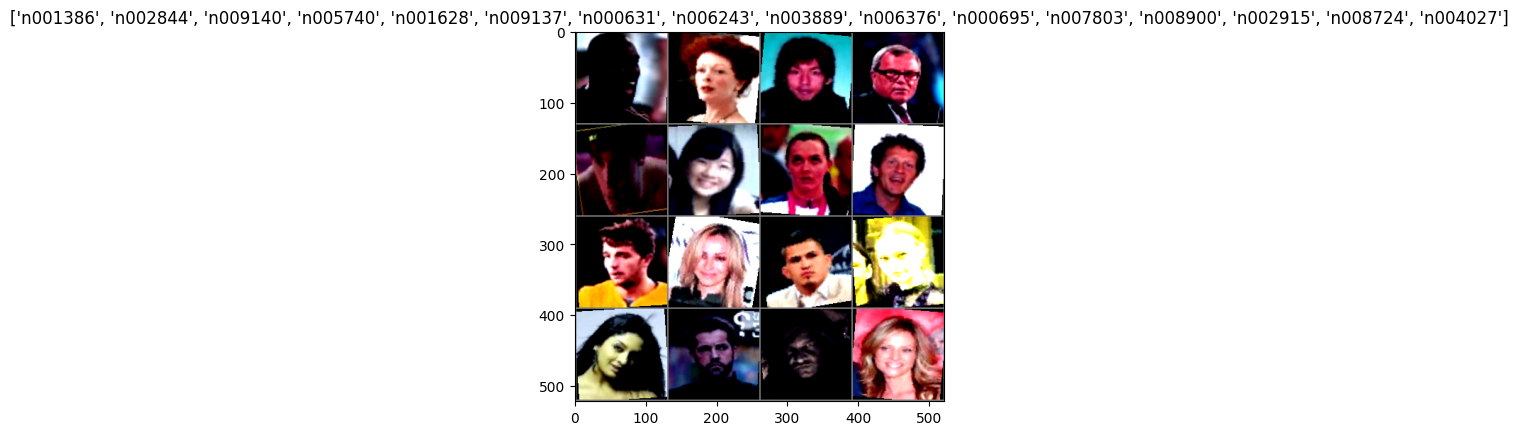

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Undo normalization to [0,1] range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Load a single batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display images in a 4x4 grid
imshow(torchvision.utils.make_grid(images[:16], nrow=4), title=[train_dataset.classes[label] for label in labels[:16]])


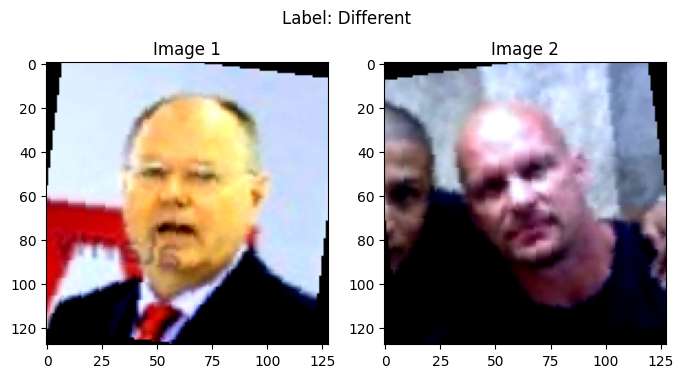

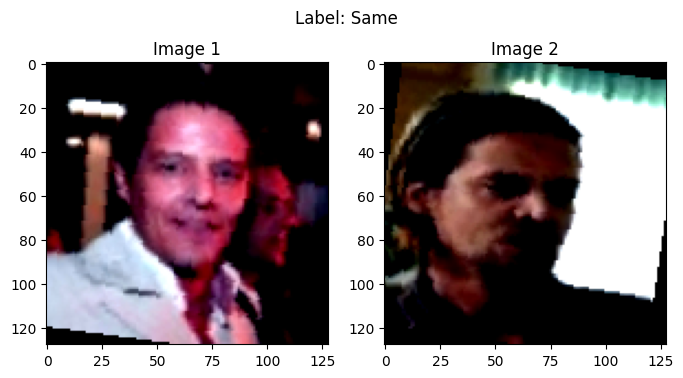

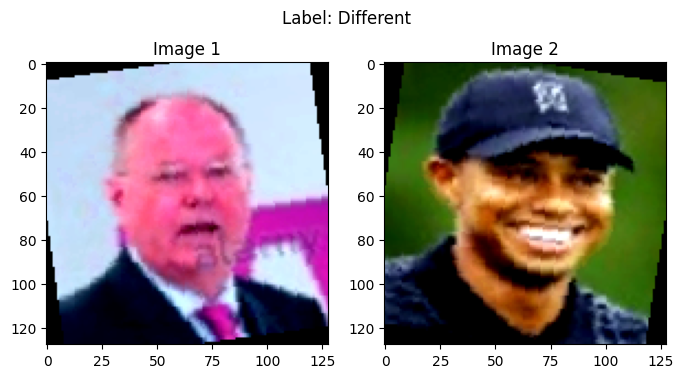

In [6]:
def show_verification_pairs(img1, img2, label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Display the first image
    img1 = img1 / 2 + 0.5  # Unnormalize
    npimg1 = img1.numpy()
    axes[0].imshow(np.transpose(npimg1, (1, 2, 0)))
    axes[0].set_title("Image 1")

    # Display the second image
    img2 = img2 / 2 + 0.5  # Unnormalize
    npimg2 = img2.numpy()
    axes[1].imshow(np.transpose(npimg2, (1, 2, 0)))
    axes[1].set_title("Image 2")

    # Display the label
    fig.suptitle(f"Label: {'Same' if label == 1 else 'Different'}")
    plt.show()

# Load a few pairs from the verification_loader
verification_iter = iter(verification_loader)
for _ in range(3):  # Display 3 pairs
    img1_batch, img2_batch, labels = next(verification_iter)
    show_verification_pairs(img1_batch[0], img2_batch[0], labels[0].item())


# **3. CLASSIFICATION MODEL**

## **1. BUILD MODEL** 

In [7]:
import os

# Path to the training data
train_data_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/train_data'

# Count the number of subdirectories, each representing a unique person
num_classes = len([name for name in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, name))])

print(f"Number of unique identities (classes): {num_classes}")


Number of unique identities (classes): 4000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationModel, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.2)

        # Second block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(p=0.2)

        # Third block
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(p=0.2)

        # Calculate the flattened dimension
        self._initialize_flattened_dimension()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_dim, 256)  # Use calculated flattened dimensions
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)

    def _initialize_flattened_dimension(self):
        # Pass a sample input tensor through the conv layers to determine the flattened size
        sample_input = torch.randn(1, 3, 128, 128)  # Example input size
        with torch.no_grad():
            x = F.relu(self.bn1(self.conv1(sample_input)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.relu(self.bn3(self.conv3(x)))
            x = self.pool1(x)
            x = self.dropout1(x)

            x = F.relu(self.bn4(self.conv4(x)))
            x = F.relu(self.bn5(self.conv5(x)))
            x = F.relu(self.bn6(self.conv6(x)))
            x = self.pool2(x)
            x = self.dropout2(x)

            x = F.relu(self.bn7(self.conv7(x)))
            x = self.pool3(x)
            x = self.dropout3(x)
        
            self.flattened_dim = x.view(1, -1).size(1)  # Get flattened dimension

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third block
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

classification_model = ClassificationModel(num_classes=num_classes)
print(classification_model)


ClassificationModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv

## **2. TRAIN MODELS**

In [ ]:
import os

# Path to the saved model
model_path = '/kaggle/working/model_checkpoint.pth'

# Check if a saved model exists and load it if available
if os.path.exists(model_path):
    classification_model.load_state_dict(torch.load(model_path))
    classification_model.eval()  # Set to evaluation mode
    print("Model loaded successfully. Skipping training.")
else:
    print("No saved model found. Proceeding to train the model.")

No saved model found. Proceeding to train the model.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes based on your dataset
classification_model = ClassificationModel(num_classes=num_classes).to(device)  # Move model to GPU

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

# Mixed precision scaler
scaler = GradScaler()

# Number of epochs
num_epochs = 20

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with formatted output
for epoch in range(num_epochs):
    start_time = time.time()  # Track time at the start of the epoch
    
    # Training Phase
    classification_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase with progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = classification_model(images)
            loss = criterion(outputs, labels)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Update metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store training metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation Phase
    classification_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            
            # Mixed precision validation pass
            with autocast():
                outputs = classification_model(images)
                loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate and store validation metrics
    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculate time per epoch
    epoch_time = time.time() - start_time
    time_per_step = epoch_time / len(train_loader)

    # Print formatted results for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} "
          f"{len(train_loader)}/{len(train_loader)} "
          f"[{'='*30}] - {epoch_time:.0f}s {time_per_step*1000:.0f}ms/step - "
          f"loss: {epoch_loss:.4f} - accuracy: {epoch_accuracy:.4f}% - "
          f"val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}%")


/tmp/ipykernel_23/4207380863.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20:   0%|          | 0/11895 [00:00<?, ?batch/s]/tmp/ipykernel_23/4207380863.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_23/4207380863.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20 11895/11895 [==============================] - 1499s 126ms/step - loss: 7.2284 - accuracy: 1.1297% - val_loss: 6.2896 - val_accuracy: 3.1125%


Epoch 2/20 11895/11895 [==============================] - 1285s 108ms/step - loss: 5.5791 - accuracy: 7.7402% - val_loss: 5.0893 - val_accuracy: 12.4750%


Epoch 3/20 11895/11895 [==============================] - 1256s 106ms/step - loss: 4.5712 - accuracy: 17.3677% - val_loss: 4.2693 - val_accuracy: 22.1000%


Epoch 4/20 11895/11895 [==============================] - 1278s 107ms/step - loss: 3.9056 - accuracy: 25.8968% - val_loss: 3.7508 - val_accuracy: 29.8000%


Epoch 5/20 11895/11895 [==============================] - 1302s 109ms/step - loss: 3.4328 - accuracy: 33.0098% - val_loss: 3.3683 - val_accuracy: 35.7625%


Epoch 6/20 11895/11895 [==============================] - 1259s 106ms/step - loss: 3.0690 - accuracy: 38.5957% - val_loss: 3.0556 - val_accuracy: 40.8000%


Epoch 7/20 11895/11895 [==============================] - 1289s 108ms/step - loss: 2.7828 - accuracy: 43.5143% - val_loss: 2.8490 - val_accuracy: 44.6875%


Epoch 8/20 11895/11895 [==============================] - 1286s 108ms/step - loss: 2.5426 - accuracy: 47.5827% - val_loss: 2.6892 - val_accuracy: 47.6375%


Epoch 9/20 11895/11895 [==============================] - 1264s 106ms/step - loss: 2.3531 - accuracy: 50.8404% - val_loss: 2.5675 - val_accuracy: 49.4875%


Epoch 10/20 11895/11895 [==============================] - 1280s 108ms/step - loss: 2.1918 - accuracy: 53.6964% - val_loss: 2.4599 - val_accuracy: 51.5875%


Epoch 11/20 11895/11895 [==============================] - 1250s 105ms/step - loss: 2.0497 - accuracy: 56.2477% - val_loss: 2.3205 - val_accuracy: 54.3000%


Epoch 12/20 11895/11895 [==============================] - 1251s 105ms/step - loss: 1.9304 - accuracy: 58.4968% - val_loss: 2.2469 - val_accuracy: 55.7625%


Epoch 13/20 11895/11895 [==============================] - 1255s 106ms/step - loss: 1.8230 - accuracy: 60.3826% - val_loss: 2.1926 - val_accuracy: 56.7750%


Epoch 14/20 11895/11895 [==============================] - 1258s 106ms/step - loss: 1.7294 - accuracy: 62.1457% - val_loss: 2.1113 - val_accuracy: 57.9750%


Epoch 15/20 11895/11895 [==============================] - 1256s 106ms/step - loss: 1.6440 - accuracy: 63.7382% - val_loss: 2.0740 - val_accuracy: 58.9000%


Epoch 16/20 11895/11895 [==============================] - 1253s 105ms/step - loss: 1.5692 - accuracy: 65.0545% - val_loss: 2.0444 - val_accuracy: 59.5125%


Epoch 17/20 11895/11895 [==============================] - 1253s 105ms/step - loss: 1.5029 - accuracy: 66.2976% - val_loss: 1.9785 - val_accuracy: 60.6000%


Epoch 18/20 11895/11895 [==============================] - 1251s 105ms/step - loss: 1.4418 - accuracy: 67.5187% - val_loss: 1.9632 - val_accuracy: 61.0750%


Epoch 19/20 11895/11895 [==============================] - 1270s 107ms/step - loss: 1.3834 - accuracy: 68.5935% - val_loss: 1.9214 - val_accuracy: 61.5250%


Epoch 20/20 11895/11895 [==============================] - 1266s 106ms/step - loss: 1.3332 - accuracy: 69.4158% - val_loss: 1.8970 - val_accuracy: 62.4500%


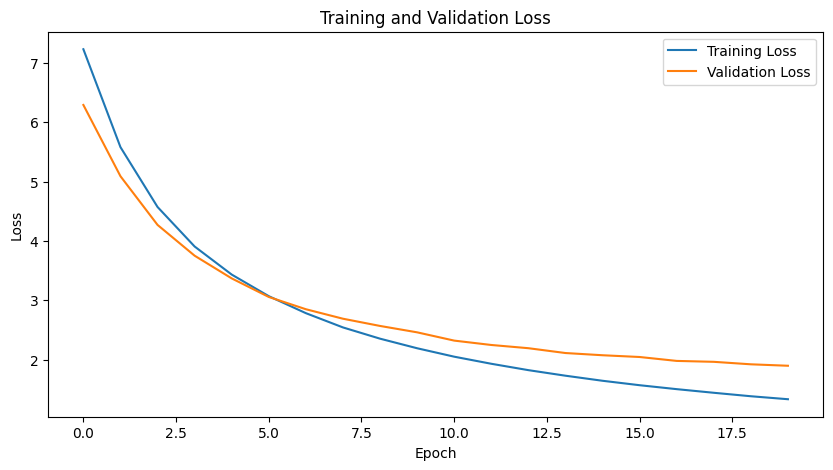

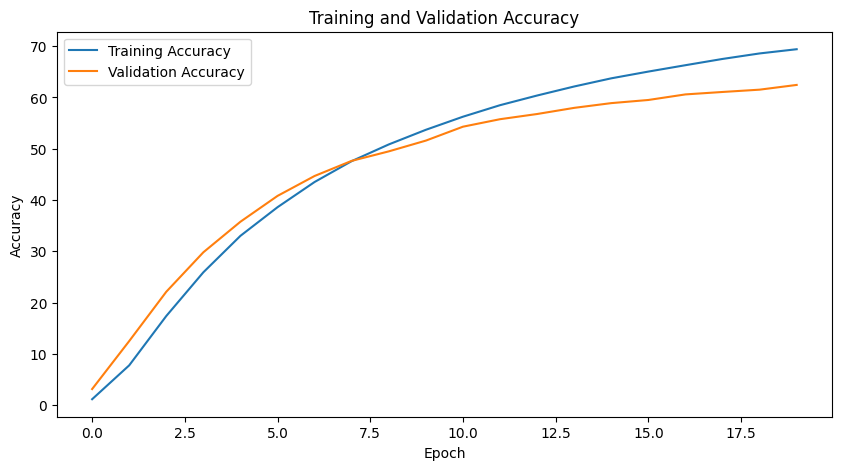

In [11]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [12]:
torch.save(classification_model.state_dict(), '/kaggle/working/model_checkpoint.pth')
print("Model saved successfully.")

Model saved successfully.


## **3.VALIDATE MODEL**

In [13]:
# After training, evaluate on the test set
classification_model.eval()  # Set model to evaluation mode
test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation for faster computation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # Mixed precision test pass
        with autocast():
            outputs = classification_model(images)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test metrics
test_loss = test_running_loss / len(test_loader.dataset)
test_accuracy = 100 * test_correct / test_total

# Print test results
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}%")

/tmp/ipykernel_23/247065606.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test Loss: 1.8586 - Test Accuracy: 63.1250%
